In [1]:
import glob
import librosa
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
import os
import pathlib
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tanvipenumudy","key":"9d7a7b8c87f18fd1e9a2b9bb31134df9"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

 98% 1.19G/1.21G [00:19<00:00, 61.0MB/s]
100% 1.21G/1.21G [00:19<00:00, 65.8MB/s]


In [5]:
!ls

gtzan-dataset-music-genre-classification.zip  kaggle.json  sample_data


In [6]:
!unzip "gtzan-dataset-music-genre-classification.zip" -d /tmp

Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: /tmp/Data/features_30_sec.csv  
  inflating: /tmp/Data/features_3_sec.csv  
  inflating: /tmp/Data/genres_original/blues/blues.00000.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00001.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00002.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00003.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00004.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00005.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00006.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00007.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00008.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00009.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00010.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00011.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00012.wav  
  inflating: /tmp/Data/genres_origina

In [7]:
import os
print(len(os.listdir('/tmp/Data/genres_original')))
print(len(os.listdir('/tmp/Data/genres_original/blues')))
print(len(os.listdir('/tmp/Data/genres_original/classical')))

10
100
100


In [8]:
temp = '/tmp/Data/genres_original/blues/blues.00083.wav'
x, sr = librosa.load(temp)
print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(661794,) 22050


In [9]:
x

array([-0.0244751 , -0.0541687 , -0.08081055, ..., -0.10940552,
       -0.03323364, -0.1116333 ], dtype=float32)

In [10]:
import csv

In [11]:
header = ['filename','chroma_stft','rmse','spectral_centroid','spectral_bandwidth','rolloff','zero_crossing_rate']
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'

In [11]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = ['blues','classical','country','disco','hiphop','metal','pop','reggae','rock']
for g in genres:
    for filename in os.listdir(f'/tmp/Data/genres_original/{g}'):
        songname = f'/tmp/Data/genres_original/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        rmse = librosa.feature.rmse(y=y)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [30]:
data = pd.read_csv('data.csv')
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00071.wav,0.305262,0.120542,2429.260934,2286.625281,5065.027706,0.134687,-89.357906,93.786055,-14.574538,54.391654,-33.508380,19.420994,-19.761601,13.026320,-13.865957,14.607766,-14.969526,10.585571,-18.026934,6.654247,-10.204747,6.527642,-10.846745,3.319423,-6.189024,2.994841,blues
1,blues.00073.wav,0.341865,0.259714,2094.919420,2158.335963,4482.447895,0.100570,-30.094571,103.732289,-19.754240,56.404770,-12.710990,20.188002,-17.340381,16.292435,-18.439600,8.924175,-11.648016,11.213472,-8.842511,9.090302,-3.579252,4.372714,-2.830807,4.725089,0.485058,1.475955,blues
2,blues.00007.wav,0.307921,0.131785,1451.754147,1577.369917,2955.348796,0.061435,-179.395447,136.459244,-26.656359,39.988027,5.289679,10.924427,-20.561889,8.513764,-11.356908,-3.469077,-8.414554,-6.954827,-3.544535,-8.051242,-8.959537,-8.424337,-10.558885,-10.788159,-4.693749,-8.638613,blues
3,blues.00000.wav,0.349943,0.130225,1784.420446,2002.650192,3806.485316,0.083066,-113.596742,121.557302,-19.158825,42.351029,-6.376457,18.618875,-13.697911,15.344630,-12.285266,10.980491,-8.324323,8.810668,-3.667367,5.751690,-5.162761,0.750947,-1.691937,-0.409954,-2.300208,1.219928,blues
4,blues.00070.wav,0.322734,0.106164,2159.546654,2130.376826,4685.046670,0.098349,-133.015981,105.722690,-22.138973,41.818620,-26.988738,19.122450,-26.566396,19.239805,-15.332086,6.986052,-10.813206,6.791205,-11.727092,4.397390,-6.039441,1.966114,-12.320324,3.253893,-8.809824,-3.379920,blues


In [31]:
data.shape

(900, 28)

In [32]:
data = data.drop(['filename'],axis=1)

In [33]:
data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.305262,0.120542,2429.260934,2286.625281,5065.027706,0.134687,-89.357906,93.786055,-14.574538,54.391654,-33.508380,19.420994,-19.761601,13.026320,-13.865957,14.607766,-14.969526,10.585571,-18.026934,6.654247,-10.204747,6.527642,-10.846745,3.319423,-6.189024,2.994841,blues
1,0.341865,0.259714,2094.919420,2158.335963,4482.447895,0.100570,-30.094571,103.732289,-19.754240,56.404770,-12.710990,20.188002,-17.340381,16.292435,-18.439600,8.924175,-11.648016,11.213472,-8.842511,9.090302,-3.579252,4.372714,-2.830807,4.725089,0.485058,1.475955,blues
2,0.307921,0.131785,1451.754147,1577.369917,2955.348796,0.061435,-179.395447,136.459244,-26.656359,39.988027,5.289679,10.924427,-20.561889,8.513764,-11.356908,-3.469077,-8.414554,-6.954827,-3.544535,-8.051242,-8.959537,-8.424337,-10.558885,-10.788159,-4.693749,-8.638613,blues
3,0.349943,0.130225,1784.420446,2002.650192,3806.485316,0.083066,-113.596742,121.557302,-19.158825,42.351029,-6.376457,18.618875,-13.697911,15.344630,-12.285266,10.980491,-8.324323,8.810668,-3.667367,5.751690,-5.162761,0.750947,-1.691937,-0.409954,-2.300208,1.219928,blues
4,0.322734,0.106164,2159.546654,2130.376826,4685.046670,0.098349,-133.015981,105.722690,-22.138973,41.818620,-26.988738,19.122450,-26.566396,19.239805,-15.332086,6.986052,-10.813206,6.791205,-11.727092,4.397390,-6.039441,1.966114,-12.320324,3.253893,-8.809824,-3.379920,blues


In [34]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [35]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [38]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(675, 26) (225, 26) (675,) (225,)


In [39]:
print(np.unique(y_train,return_counts=True))
print(np.unique(y_test,return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([65, 82, 79, 73, 74, 81, 74, 69, 78]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([35, 18, 21, 27, 26, 19, 26, 31, 22]))


In [40]:
from keras.utils import to_categorical

In [41]:
#One-hot encoding 
print("Before:", y_train.shape)
print("Before:", y_test.shape)
y_train = to_categorical(y_train, 9)
y_test = to_categorical(y_test, 9)
print("After: ", y_train.shape)
print("After: ", y_test.shape)

Before: (675,)
Before: (225,)
After:  (675, 9)
After:  (225, 9)


In [43]:
X_train = X_train.reshape(-1, 1, 26)
X_test  = X_test.reshape(-1, 1, 26)

In [44]:
from tensorflow.keras.layers import Dense,LSTM,GRU,SimpleRNN
import time

In [45]:
layer = [1,2,3,4]
l_train, l_test, tl, pl = [],[],[],[]
for i in range(len(layer)):
    model=Sequential()
    model.add(SimpleRNN(32,input_shape=(1, 26))) 
    for j in range(layer[i]):
        model.add(Dense(32, activation="tanh"))
    model.add(Dense(9, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    t=time.time()
    model.fit(X_train,y_train,epochs=100)
    tl.append(time.time()-t)
    pl.append(model.count_params())
    print("Time taken:", time.time()-t)
    print("Parameters:", model.count_params())
    l_train.append(model.evaluate(X_train,y_train,verbose = False)[-1])
    l_test.append(model.evaluate(X_test,y_test,verbose = False)[-1])

Epoch 1/100
22/22 [==============================] - 0s 3ms/step - loss: 2.0311 - accuracy: 0.2370
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 1.6349 - accuracy: 0.3941
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 1.4805 - accuracy: 0.4489
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 1.3818 - accuracy: 0.4874
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 1.3111 - accuracy: 0.5422
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 1.2471 - accuracy: 0.5541
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 1.1946 - accuracy: 0.5926
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 1.1458 - accuracy: 0.6341
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 1.1085 - accuracy: 0.6519
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 1.0689 - accuracy: 0.6593
Epoch 11/

In [46]:
nodes = [16,32,64,128]
n_train, n_test, tn, pn = [],[],[],[]
for i in nodes:
    model=Sequential()
    model.add(SimpleRNN(32,input_shape=(1, 26))) 
    model.add(Dense(i,activation="tanh"))
    model.add(Dense(9,activation="softmax"))
    model.compile(loss='categorical_crossentropy',metrics=['accuracy']
              ,optimizer='adam')
    t=time.time()
    model.fit(X_train,y_train,epochs=100)
    tn.append(time.time()-t)
    pn.append(model.count_params())
    print("Time taken:", time.time()-t)
    print("Parameters:", model.count_params())
    n_train.append(model.evaluate(X_train,y_train,verbose = False)[-1])
    n_test.append(model.evaluate(X_test,y_test,verbose = False)[-1])

Epoch 1/100
22/22 [==============================] - 0s 3ms/step - loss: 2.0315 - accuracy: 0.2785
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 1.7138 - accuracy: 0.4000
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 1.5723 - accuracy: 0.4415
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 1.4817 - accuracy: 0.4830
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 1.4039 - accuracy: 0.5215
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 1.3453 - accuracy: 0.5452
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 1.2954 - accuracy: 0.5481
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 1.2508 - accuracy: 0.5733
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 1.2107 - accuracy: 0.5896
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 1.1745 - accuracy: 0.6089
Epoch 11/

In [47]:
import matplotlib.pyplot as plt

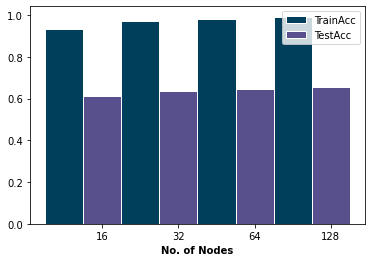

In [48]:
layer=[str(i) for i in layer]
nodes=[str(i) for i in nodes]

barWidth = 0.50

bars1 = n_train
bars2 = n_test

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white', label='TrainAcc')
plt.bar(r2, bars2, color='#58508d', width=barWidth, edgecolor='white', label='TestAcc')

plt.xlabel('No. of Nodes', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in nodes])
 
plt.legend()
plt.show()

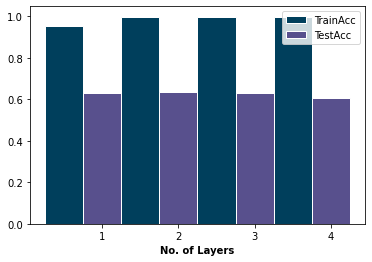

In [49]:
barWidth = 0.50

bars1 = l_train
bars2 = l_test

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white', label='TrainAcc')
plt.bar(r2, bars2, color='#58508d', width=barWidth, edgecolor='white', label='TestAcc')

plt.xlabel('No. of Layers', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in layer])
 
plt.legend()
plt.show()

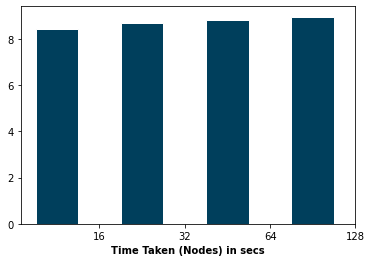

In [50]:
barWidth = 0.50
bars1 = tn
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Time Taken (Nodes) in secs', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in nodes])
plt.show()

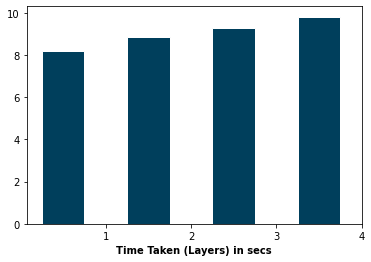

In [51]:
barWidth = 0.50
bars1 = tl
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Time Taken (Layers) in secs', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in layer])
plt.show()

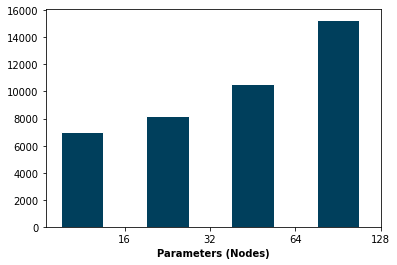

In [52]:
barWidth = 0.50
bars1 = pn
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Parameters (Nodes)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in nodes])
plt.show()

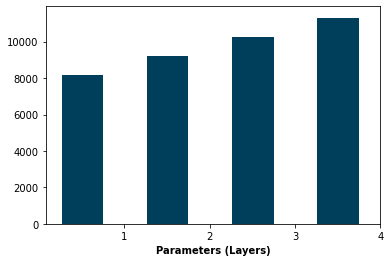

In [53]:
barWidth = 0.50
bars1 = pl
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Parameters (Layers)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in layer])
plt.show()

In [55]:
y_train = y_train.reshape(-1, 1, 9)
y_test  = y_test.reshape(-1, 1, 9)

In [57]:
layer = [1,2,3,4]
l_train, l_test, tl, pl = [],[],[],[]
for i in range(len(layer)):
    model=Sequential()
    model.add(LSTM(32, return_sequences=True,
               input_shape=(1, 26)))
    for j in range(layer[i]):
        model.add(LSTM(32, return_sequences=True))
    model.add(Dense(9, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    t=time.time()
    model.fit(X_train,y_train,epochs=100)
    tl.append(time.time()-t)
    pl.append(model.count_params())
    print("Time taken:", time.time()-t)
    print("Parameters:", model.count_params())
    l_train.append(model.evaluate(X_train,y_train,verbose = False)[-1])
    l_test.append(model.evaluate(X_test,y_test,verbose = False)[-1])

Epoch 1/100
22/22 [==============================] - 0s 4ms/step - loss: 2.1763 - accuracy: 0.2356
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 2.1246 - accuracy: 0.3600
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 2.0475 - accuracy: 0.4030
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 1.9374 - accuracy: 0.3911
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 1.8238 - accuracy: 0.3852
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 1.7247 - accuracy: 0.3896
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 1.6390 - accuracy: 0.3852
Epoch 8/100
22/22 [==============================] - 0s 4ms/step - loss: 1.5680 - accuracy: 0.4119
Epoch 9/100
22/22 [==============================] - 0s 4ms/step - loss: 1.5053 - accuracy: 0.4237
Epoch 10/100
22/22 [==============================] - 0s 4ms/step - loss: 1.4479 - accuracy: 0.4474
Epoch 11/

In [58]:
nodes = [16,32,64,128]
n_train, n_test, tn, pn = [],[],[],[]
for i in nodes:
    model=Sequential()
    model.add(LSTM(32, return_sequences=True,
               input_shape=(1, 26))) 
    model.add(LSTM(i, return_sequences=True))
    model.add(Dense(9,activation="softmax"))
    model.compile(loss='categorical_crossentropy',metrics=['accuracy']
              ,optimizer='adam')
    t=time.time()
    model.fit(X_train,y_train,epochs=100)
    tn.append(time.time()-t)
    pn.append(model.count_params())
    print("Time taken:", time.time()-t)
    print("Parameters:", model.count_params())
    n_train.append(model.evaluate(X_train,y_train,verbose = False)[-1])
    n_test.append(model.evaluate(X_test,y_test,verbose = False)[-1])

Epoch 1/100
22/22 [==============================] - 0s 5ms/step - loss: 2.1828 - accuracy: 0.1926
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 2.1395 - accuracy: 0.3304
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 2.0799 - accuracy: 0.3659
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 1.9986 - accuracy: 0.3526
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 1.9062 - accuracy: 0.3481
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 1.8214 - accuracy: 0.3511
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 1.7476 - accuracy: 0.3600
Epoch 8/100
22/22 [==============================] - 0s 5ms/step - loss: 1.6847 - accuracy: 0.3704
Epoch 9/100
22/22 [==============================] - 0s 5ms/step - loss: 1.6285 - accuracy: 0.3911
Epoch 10/100
22/22 [==============================] - 0s 4ms/step - loss: 1.5723 - accuracy: 0.4163
Epoch 11/

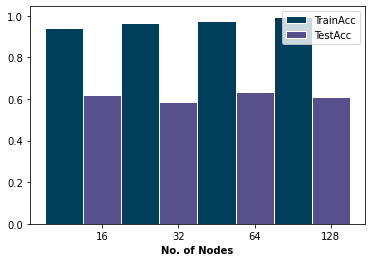

In [59]:
layer=[str(i) for i in layer]
nodes=[str(i) for i in nodes]

barWidth = 0.50

bars1 = n_train
bars2 = n_test

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white', label='TrainAcc')
plt.bar(r2, bars2, color='#58508d', width=barWidth, edgecolor='white', label='TestAcc')

plt.xlabel('No. of Nodes', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in nodes])
 
plt.legend()
plt.show()

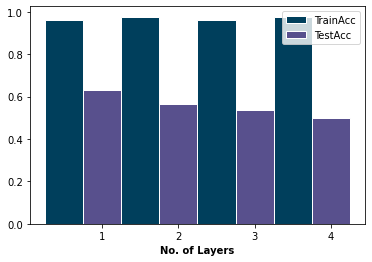

In [60]:
barWidth = 0.50

bars1 = l_train
bars2 = l_test

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white', label='TrainAcc')
plt.bar(r2, bars2, color='#58508d', width=barWidth, edgecolor='white', label='TestAcc')

plt.xlabel('No. of Layers', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in layer])
 
plt.legend()
plt.show()

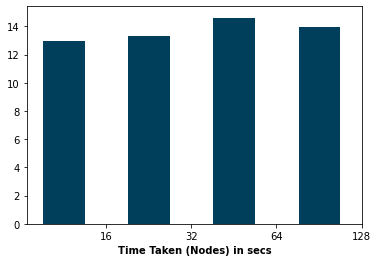

In [61]:
barWidth = 0.50
bars1 = tn
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Time Taken (Nodes) in secs', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in nodes])
plt.show()

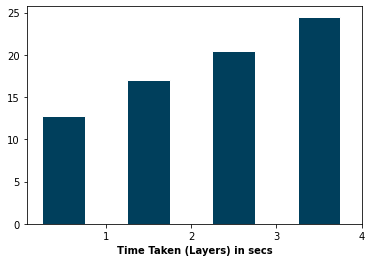

In [62]:
barWidth = 0.50
bars1 = tl
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Time Taken (Layers) in secs', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in layer])
plt.show()

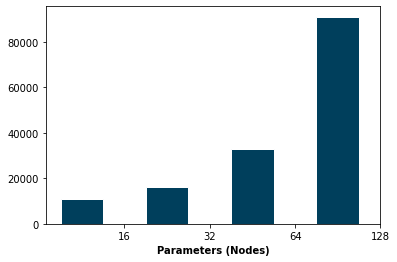

In [63]:
barWidth = 0.50
bars1 = pn
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Parameters (Nodes)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in nodes])
plt.show()

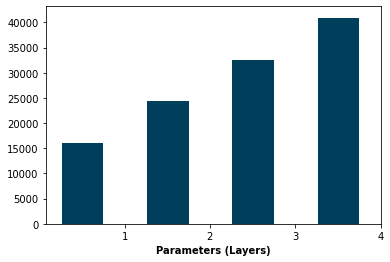

In [64]:
barWidth = 0.50
bars1 = pl
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Parameters (Layers)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in layer])
plt.show()

In [65]:
layer = [1,2,3,4]
l_train, l_test, tl, pl = [],[],[],[]
for i in range(len(layer)):
    model=Sequential()
    model.add(GRU(32, return_sequences=True,
               input_shape=(1, 26)))
    for j in range(layer[i]):
        model.add(GRU(32, return_sequences=True))
    model.add(Dense(9, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    t=time.time()
    model.fit(X_train,y_train,epochs=100)
    tl.append(time.time()-t)
    pl.append(model.count_params())
    print("Time taken:", time.time()-t)
    print("Parameters:", model.count_params())
    l_train.append(model.evaluate(X_train,y_train,verbose = False)[-1])
    l_test.append(model.evaluate(X_test,y_test,verbose = False)[-1])
    model = Sequential()

Epoch 1/100
22/22 [==============================] - 0s 4ms/step - loss: 2.1462 - accuracy: 0.2281
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 1.9872 - accuracy: 0.3881
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 1.8334 - accuracy: 0.3763
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 1.7029 - accuracy: 0.3748
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 1.6059 - accuracy: 0.3941
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 1.5276 - accuracy: 0.4148
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 1.4558 - accuracy: 0.4563
Epoch 8/100
22/22 [==============================] - 0s 4ms/step - loss: 1.3880 - accuracy: 0.4978
Epoch 9/100
22/22 [==============================] - 0s 4ms/step - loss: 1.3258 - accuracy: 0.5452
Epoch 10/100
22/22 [==============================] - 0s 4ms/step - loss: 1.2673 - accuracy: 0.5689
Epoch 11/

In [66]:
nodes = [16,32,64,128]
n_train, n_test, tn, pn = [],[],[],[]
for i in nodes:
    model=Sequential()
    model.add(GRU(32, return_sequences=True,
               input_shape=(1, 26)))
    model.add(GRU(i, return_sequences=True))
    model.add(Dense(9,activation="softmax"))
    model.compile(loss='categorical_crossentropy',metrics=['accuracy']
              ,optimizer='adam')
    t=time.time()
    model.fit(X_train,y_train,epochs=100)
    tn.append(time.time()-t)
    pn.append(model.count_params())
    print("Time taken:", time.time()-t)
    print("Parameters:", model.count_params())
    n_train.append(model.evaluate(X_train,y_train,verbose = False)[-1])
    n_test.append(model.evaluate(X_test,y_test,verbose = False)[-1])

Epoch 1/100
22/22 [==============================] - 0s 4ms/step - loss: 2.1458 - accuracy: 0.2667
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 2.0465 - accuracy: 0.3926
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 1.9476 - accuracy: 0.4252
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 1.8445 - accuracy: 0.4385
Epoch 5/100
22/22 [==============================] - 0s 5ms/step - loss: 1.7472 - accuracy: 0.4400
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 1.6603 - accuracy: 0.4578
Epoch 7/100
22/22 [==============================] - 0s 5ms/step - loss: 1.5858 - accuracy: 0.4548
Epoch 8/100
22/22 [==============================] - 0s 5ms/step - loss: 1.5204 - accuracy: 0.4770
Epoch 9/100
22/22 [==============================] - 0s 4ms/step - loss: 1.4620 - accuracy: 0.5022
Epoch 10/100
22/22 [==============================] - 0s 4ms/step - loss: 1.4076 - accuracy: 0.5052
Epoch 11/

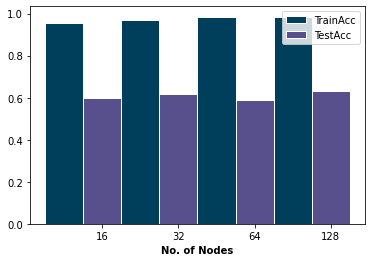

In [67]:
layer=[str(i) for i in layer]
nodes=[str(i) for i in nodes]

barWidth = 0.50

bars1 = n_train
bars2 = n_test

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white', label='TrainAcc')
plt.bar(r2, bars2, color='#58508d', width=barWidth, edgecolor='white', label='TestAcc')

plt.xlabel('No. of Nodes', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in nodes])
 
plt.legend()
plt.show()

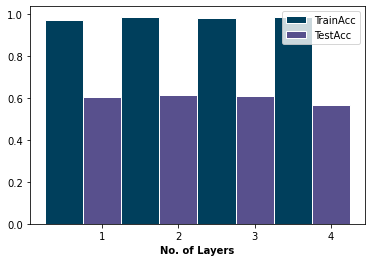

In [68]:
barWidth = 0.50

bars1 = l_train
bars2 = l_test

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white', label='TrainAcc')
plt.bar(r2, bars2, color='#58508d', width=barWidth, edgecolor='white', label='TestAcc')

plt.xlabel('No. of Layers', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in layer])
 
plt.legend()
plt.show()

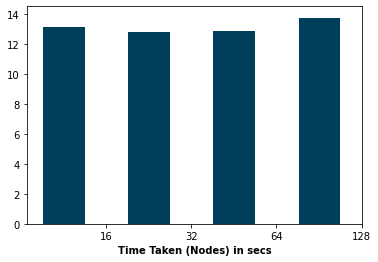

In [69]:
barWidth = 0.50
bars1 = tn
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Time Taken (Nodes) in secs', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in nodes])
plt.show()

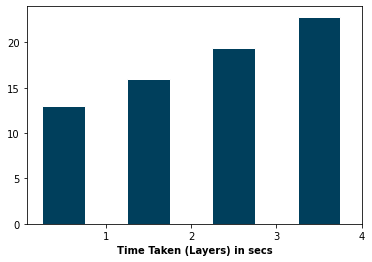

In [70]:
barWidth = 0.50
bars1 = tl
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Time Taken (Layers) in secs', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in layer])
plt.show()

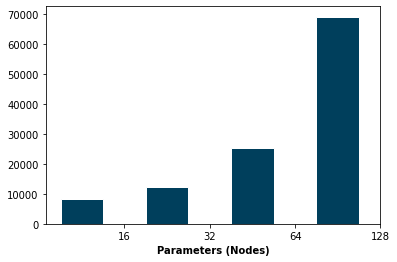

In [71]:
barWidth = 0.50
bars1 = pn
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Parameters (Nodes)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in nodes])
plt.show()

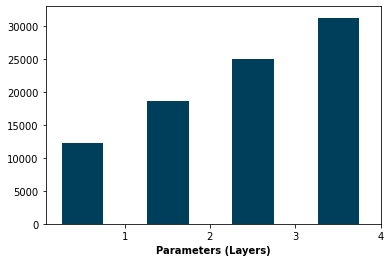

In [72]:
barWidth = 0.50
bars1 = pl
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Parameters (Layers)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in layer])
plt.show()